The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/soln/chap11.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_corr

(chapter-modulation-and-sampling)=
# Modulation and Sampling

In Section xxx we saw that when a signal is sampled at 10,000 Hz, a component at 5500 Hz is indistinguishable from a component at 4500 Hz.
In this example, the folding frequency, 5000 Hz, is half of the sampling rate.
But I didn't explain why.

This chapter explores the effect of sampling and presents the Sampling Theorem, which explains aliasing and the folding frequency.

I'll start by exploring the effect of convolution with impulses; then I'll use that effect to explain amplitude modulation (AM), which turns out to be useful for understanding the Sampling Theorem.

In [4]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP/raw/v2/nb/thinkdsp.py")

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_corr

(section-convolution-with-impulses)=
## Convolution With Impulses

As we saw in Section xxx, convolution of a signal with a series of impulses has the effect of making shifted, scaled copies of the signal.

As an example, I'll read signal that sounds like a beep:

In [6]:
download('https://github.com/AllenDowney/ThinkDSP/raw/v2/soln/253887__themusicalnomad__positive-beeps.wav')

In [7]:
from thinkdsp import read_wave

filename = '253887__themusicalnomad__positive-beeps.wav'
wave = read_wave(filename)
wave.normalize()

And I'll construct a wave with four impulses:

In [8]:
from thinkdsp import Impulses

imp_sig = Impulses([0.005, 0.3, 0.6,  0.9],
                       amps=[1,     0.5, 0.25, 0.1])
impulses = imp_sig.make_wave(start=0, duration=1.0,
                             framerate=wave.framerate)

And then convolve them:

In [9]:
convolved = wave.convolve(impulses)

The following figure shows the results, with the signal in the top left, the impulses in the lower left, and the result on the right.

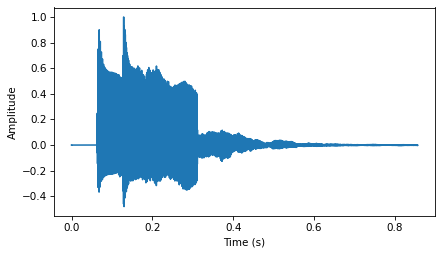

In [10]:
wave.plot()
decorate_time()

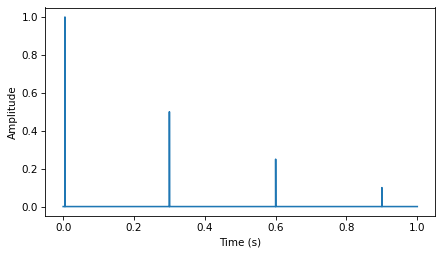

In [11]:
impulses.plot()
decorate_time()

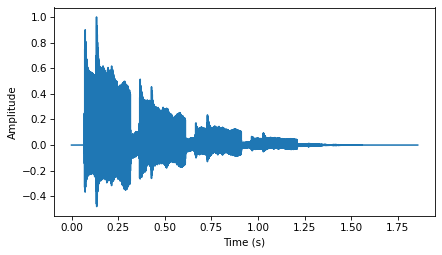

In [12]:
convolved = wave.convolve(impulses)

convolved.plot()
decorate_time()

You can hear the result in `chap11.ipynb`; it sounds like a series of four beeps with decreasing loudness.

The point of this example is just to demonstrate that convolution with impulses makes shifted, scaled copies.
This result will be useful in the next section.


(section-amplitude-modulation)=
## Amplitude Modulation

Amplitude modulation (AM) is used to broadcast AM radio, among other applications.
At the transmitter, the signal (which might contain speech, music, etc.) is "modulated" by multiplying it with a cosine signal that acts as a "carrier wave".
The result is a high-frequency wave that is suitable for broadcast by radio.
Typical frequencies for AM radio in the United States are 500--1600 kHz (see <https://en.wikipedia.org/wiki/AM_broadcasting>).

At the receiving end, the broadcast signal is "demodulated" to recover the original signal.
Surprisingly, demodulation works by multiplying the broadcast signal, again, by the same carrier wave.

To see how that works, I'll modulate a signal with a carrier wave at 10 kHz.
Here's the signal:

In [13]:
download('https://github.com/AllenDowney/ThinkDSP/raw/v2/soln/105977__wcfl10__favorite-station.wav')

In [14]:
filename = '105977__wcfl10__favorite-station.wav'
wave = read_wave(filename)
wave.unbias()
wave.normalize()

And here's the carrier:

In [15]:
from thinkdsp import CosSignal

carrier_sig = CosSignal(freq=10000)
carrier_wave = carrier_sig.make_wave(duration=wave.duration,
                                     framerate=wave.framerate)

We can multiply them using the operator, which multiplies the wave arrays elementwise:

In [16]:
modulated = wave * carrier_wave

The result sounds pretty bad.
You can hear it in `chap11.ipynb`.

The following figure shows what's happening in the frequency domain.

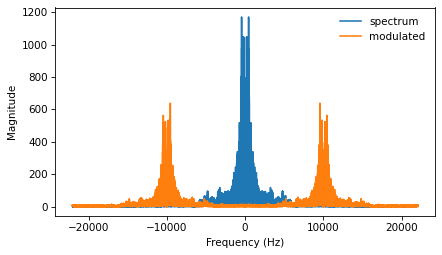

In [17]:
spectrum = wave.make_spectrum(full=True)
spectrum.plot(label='spectrum')
modulated.make_spectrum(full=True).plot(label='modulated')
decorate_freq()

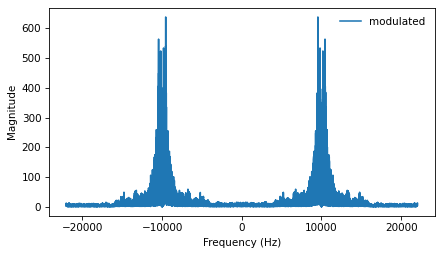

In [18]:
modulated.make_spectrum(full=True).plot(label='modulated')
decorate_freq()

The top row is the spectrum of the original signal.
The next row is the spectrum of the modulated signal, after multiplying by the carrier.
It contains two copies of the original spectrum, shifted by plus and minus 10 kHz.

To understand why, recall that convolution in the time domain corresponds to multiplication in the frequency domain.
Conversely, multiplication in the time domain corresponds to convolution in the frequency domain.
When we multiply the signal by the carrier, we are convolving its spectrum with the DFT of the carrier.

Since the carrier is a simple cosine wave, its DFT is two impulses, at plus and minus 10 kHz.
Convolution with these impulses makes shifted, scaled copies of the spectrum.
Notice that the amplitude of the spectrum is smaller after modulation.
The energy from the original signal is split between the copies.

We demodulate the signal, by multiplying by the carrier wave again:

In [19]:
demodulated = modulated * carrier_wave

The following figure shows the result.

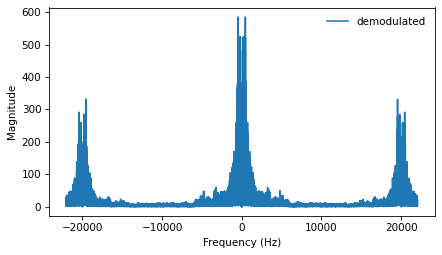

In [20]:
demodulated_spectrum = demodulated.make_spectrum(full=True)
demodulated_spectrum.plot(label='demodulated')
decorate_freq()

Again, multiplication in the time domain corresponds to convolution in the frequency domain, which makes shifted, scaled copies of the spectrum.

Since the modulated spectrum contains two peaks, each peak gets split in half and shifted by plus and minus 20 kHz.
Two of the copies meet at 0 kHz and get added together; the other two copies end up centered at plus and minus 20 kHz.

If you listen to the demodulated signal, it sounds pretty good.
The extra copies of the spectrum add high frequency components that were not it the original signal, but they are so high that your speakers probably can't play them, and most people can't hear them.
But if you have good speakers and good ears, you might.

In that case, you can get rid of the extra components by applying a low-pass filter:

In [21]:
demodulated_spectrum = demodulated.make_spectrum(full=True)
demodulated_spectrum.low_pass(10000)

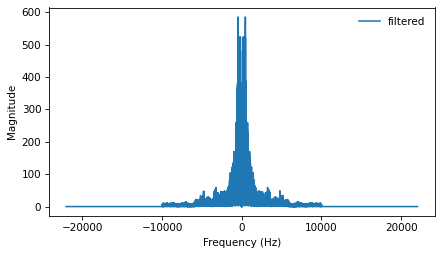

In [22]:
demodulated_spectrum.plot(label='filtered')
decorate_freq()

In [23]:
filtered = demodulated_spectrum.make_wave()

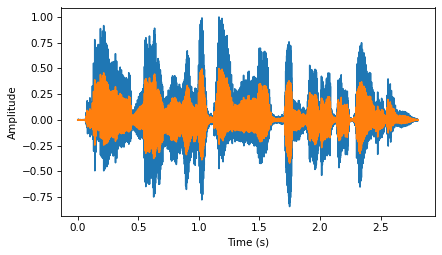

In [24]:
wave.plot()
filtered.plot()
decorate_time()

The result is quite close to the original wave, although about half of the power is lost after demodulating and filtering.
But that's not a problem in practice, because much more of the power is lost in transmitting and receiving the broadcast signal.
We have to amplify the result anyway, another factor of 2 is not an issue.


(section-sampling)=
## Sampling

I explained amplitude modulation in part because it is interesting, but mostly because it will help us understand sampling.
"Sampling" is the process of measuring an analog signal at a series of points in time, usually with equal spacing.

For example, the WAV files we have used as examples were recorded by sampling the output of a microphone using an analog-to-digital converter (ADC).
The sampling rate for most of them is 44.1 kHz, which is the standard rate for "CD quality" sound, or 48 kHz, which is the standard for DVD sound.

At 48 kHz, the folding frequency is 24 kHz, which is higher than most people can hear (see <https://en.wikipedia.org/wiki/Hearing_range>).

In most of these waves, each sample has 16 bits, so there are $2^{16}$ distinct levels.
This "bit depth" turns out to be enough that adding more bits does not improve the sound quality noticeably (see <https://en.wikipedia.org/wiki/Digital_audio>).

Of course, applications other than audio signals might require higher sampling rates, in order to capture higher frequencies, or higher bit-depth, in order to reproduce waveforms with more fidelity.

To demonstrate the effect of the sampling process, I am going to start with a wave sampled at 44.1 kHz and select samples from it at about 11 kHz.
This is not exactly the same as sampling from an analog signal, but the effect is the same.

First I'll load a recording of a drum solo:

In [25]:
download('https://github.com/AllenDowney/ThinkDSP/raw/v2/soln/263868__kevcio__amen-break-a-160-bpm.wav')

In [26]:
filename = '263868__kevcio__amen-break-a-160-bpm.wav'
wave = read_wave(filename)
wave.normalize()

The following figure shows the spectrum of this wave.

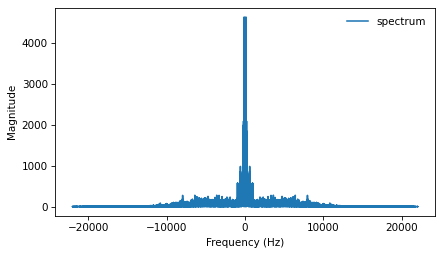

In [27]:
wave.make_spectrum(full=True).plot(label='spectrum')
decorate_freq()

Now here's the function that samples from the wave:

In [28]:
from thinkdsp import Wave

def sample(wave, factor=4):
    """Simulates sampling of a wave.
    
    wave: Wave object
    factor: ratio of the new framerate to the original
    """
    ys = np.zeros(len(wave))
    ys[::factor] = wave.ys[::factor]
    return Wave(ys, framerate=wave.framerate)

I'll use it to select every fourth element:

In [29]:
sampled = sample(wave, 4)

The result has the same framerate as the original, but most of the elements are zero.
If you play the sampled wave, it doesn't sound very good.
The sampling process introduces high-frequency components that were not in the original.

The following figure shows the spectrum of the sampled wave.
It contains four copies of the original spectrum (it looks like five copies because one is split between the highest and lowest frequencies).

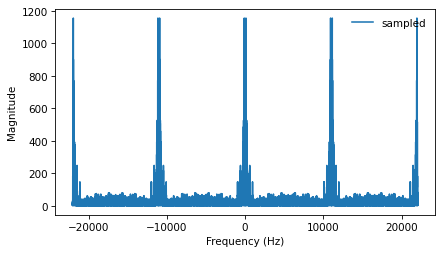

In [30]:
sampled.make_spectrum(full=True).plot(label='sampled')

decorate_freq()

To understand where these copies come from, we can think of the sampling process as multiplication with a series of impulses.
Instead of using `sample` to select every fourth element, we could use this function to make a series of impulses, sometimes called an **impulse train**:

In [31]:
def make_impulses(wave, factor):
    """Make an impulse train for sampling.
    
    wave: Wave object
    factor: spacing between impulses
    """
    ys = np.zeros(len(wave))
    ys[::factor] = 1
    ts = np.arange(len(wave)) / wave.framerate
    return Wave(ys, ts, wave.framerate)

And then multiply the original wave by the impulse train:

In [32]:
impulses = make_impulses(wave, 4)
sampled = wave * impulses

The result is the same; it still doesn't sound very good, but now we understand why.
Multiplication in the time domain corresponds to convolution in the frequency domain.
When we multiply by an impulse train, we are convolving with the DFT of an impulse train.
As it turns out, the DFT of an impulse train is also an impulse train.

The following figure shows two examples.

In [33]:
def show_impulses(wave, factor):
    """Show the impulse train and its spectrum.
    
    wave: Wave object
    factor: spacing between impulses
    """
    impulses = make_impulses(wave, factor)
    impulses.segment(0, 0.001).plot_vlines(linewidth=2, xfactor=1000)
    decorate_time()
    
    impulses.make_spectrum(full=True).plot()
    decorate_freq()

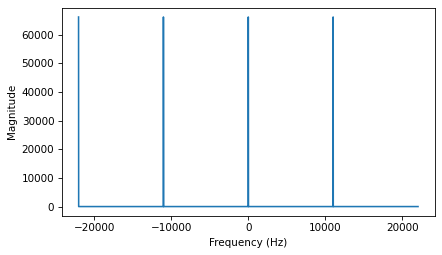

In [34]:
show_impulses(wave, 4)

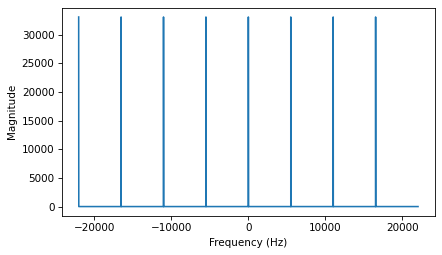

In [35]:
show_impulses(wave, 8)

The top row is the impulse train in the example, with frequency 11,025 Hz.
The DFT is a train of 4 impulses, which is why we get 4 copies of the spectrum.
The bottom row shows an impulse train with a lower frequency, about 5512 Hz.
Its DFT is a train of 8 impulses.
In general, more impulses in the time domain correspond to fewer impulses in the frequency domain.

In summary:

-   We can think of sampling as multiplication by an impulse train.

-   Multiplying by an impulse train corresponds to convolution with an impulse train in the frequency domain.

-   Convolution with an impulse train makes multiple copies of the signal's spectrum.


(section-aliasing)=
## Aliasing

Section [\[am\]](#am){reference-type="ref" reference="am"}, after demodulating an AM signal we got rid of the extra copies of the spectrum by applying a low-pass filter.
We can do the same thing after sampling, but it turns out not to be a perfect solution.

The following figure shows why not.

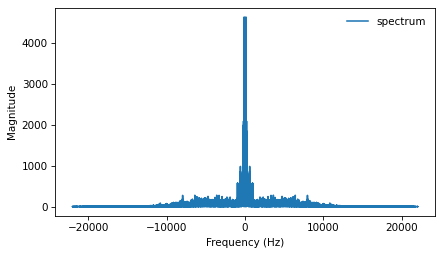

In [36]:
wave.make_spectrum(full=True).plot(label='spectrum')
decorate_freq()

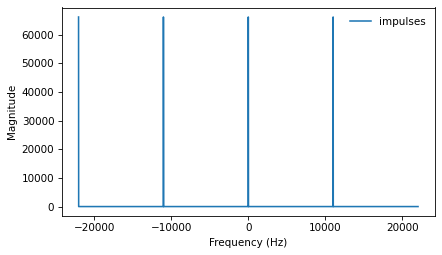

In [37]:
impulses = make_impulses(wave, 4)
impulses.make_spectrum(full=True).plot(label='impulses')
decorate_freq()

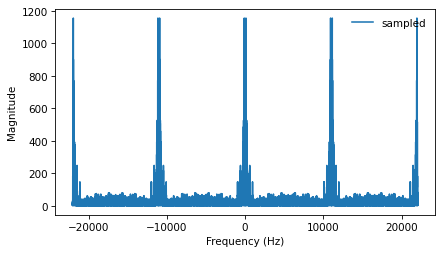

In [38]:
sampled = wave * impulses
spectrum = sampled.make_spectrum(full=True)
spectrum.plot(label='sampled')
decorate_freq()

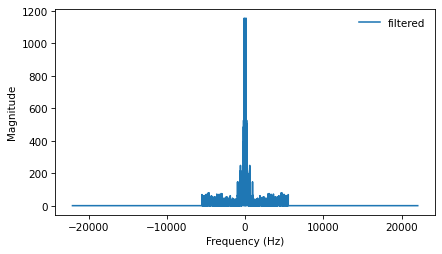

In [39]:
spectrum.low_pass(5512.5)
spectrum.plot(label='filtered')
decorate_freq()

The top row is the spectrum of the drum solo.
It contains high frequency components that extend past 10 kHz.
When we sample this wave, we convolve the spectrum with the impulse train (second row), which makes copies of the spectrum (third row).
The bottom row shows the result after applying a low-pass filter with a cutoff at the folding frequency, 5512 Hz.

If we convert the result back to a wave, it is similar to the original wave, but there are two problems:

-   Because of the low-pass filter, the components above 5500 Hz have been lost, so the result sounds muted.

-   Even the components below 5500 Hz are not quite right, because the include contributions from leftover from the spectral copies we tried to filter out.


If the spectral copies overlap after sampling, we lose information about the spectrum, and we won't be able to recover it.

But if the copies don't overlap, things work out pretty well.
As a second example, I loaded a recording of a bass guitar solo.

The following figure shows its spectrum (top row), which contains no visible energy above 5512 Hz. The second row shows the spectrum of the sampled wave, and the third row shows the spectrum after the low pass filter.

In [40]:
download('https://github.com/AllenDowney/ThinkDSP/raw/v2/soln/328878__tzurkan__guitar-phrase-tzu.wav')

In [41]:
wave = read_wave('328878__tzurkan__guitar-phrase-tzu.wav')
wave.normalize()

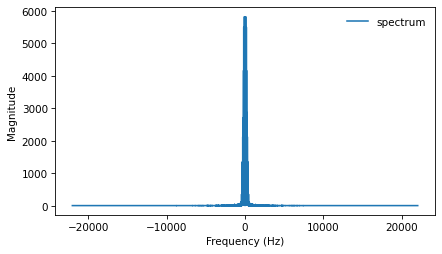

In [42]:
wave.make_spectrum(full=True).plot(label='spectrum')
decorate_freq()

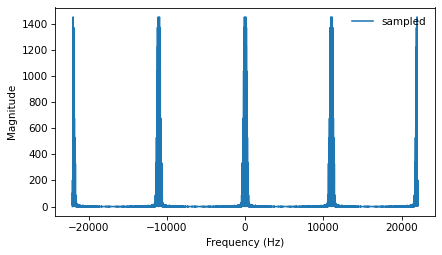

In [43]:
impulses = make_impulses(wave, 4)
sampled = wave * impulses
spectrum = sampled.make_spectrum(full=True)
spectrum.plot(label='sampled')
decorate_freq()

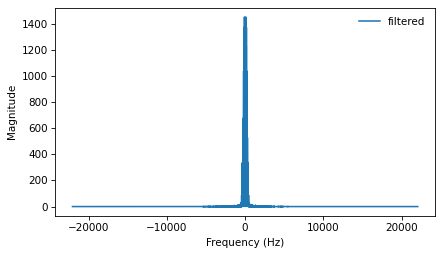

In [44]:
spectrum.low_pass(5512.5)
spectrum.plot(label='filtered')
decorate_freq()

The amplitude is lower because we've filtered out some of the energy, but the shape of the spectrum is almost exactly what we started with.
And if we convert back to a wave, it sounds the same.


(section-interpolation)=
## Interpolation

The low pass filter I used in the last step is a so-called **brick wall filter**; frequencies above the cutoff are removed completely, as if they hit a brick wall.

The following figure shows what this filter looks like.

In [45]:
from thinkdsp import Spectrum

def make_boxcar(spectrum, factor):
    """Makes a boxcar filter for the given spectrum.
    
    spectrum: Spectrum to be filtered
    factor: sampling factor
    """
    fs = np.copy(spectrum.fs)
    hs = np.zeros_like(spectrum.hs)
    
    cutoff = spectrum.framerate / 2 / factor
    for i, f in enumerate(fs):
        if abs(f) <= cutoff:
            hs[i] = 1
    return Spectrum(hs, fs, spectrum.framerate, full=spectrum.full)

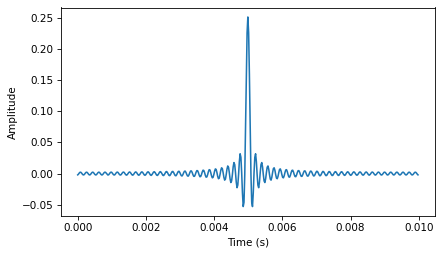

In [46]:
start = 1.0
duration = 0.01
factor = 4

short = wave.segment(start=start, duration=duration)

sampled = sample(short, factor)

spectrum = sampled.make_spectrum(full=True)
boxcar = make_boxcar(spectrum, factor)

sinc = boxcar.make_wave()
sinc.shift(sampled.ts[0])
sinc.roll(len(sinc)//2)

sinc.plot()
decorate_time()

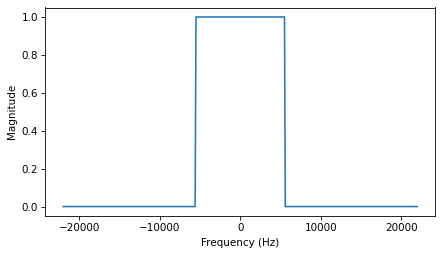

In [47]:
boxcar.plot()
decorate_freq()

Of course, multiplication by this filter, in the frequency domain, corresponds to convolution with a window in the time domain.
We can find out what that window is by computing the inverse DFT of the filter, which is shown in the following figure.

In [48]:
def plot_sinc_demo(wave, factor, start=None, duration=None):
    """Plot sinc interpolation demonstration.
    
    wave: Wave object
    factor: sampling factor
    start: start time for segment (optional)
    duration: duration of segment (optional)
    """

    def make_sinc(t, i, y):
        """Makes a shifted, scaled copy of the sinc function."""
        sinc = boxcar.make_wave()
        sinc.shift(t)
        sinc.roll(i)
        sinc.scale(y * factor)
        return sinc
 
    def plot_mini_sincs(wave):
        """Plots sinc functions for each sample in wave."""
        t0 = wave.ts[0]
        for i in range(0, len(wave), factor):
            sinc = make_sinc(t0, i, wave.ys[i])
            seg = sinc.segment(start, duration)
            seg.plot(color='green', linewidth=0.5, alpha=0.3)
            if i == 0:
                total = sinc
            else:
                total += sinc
            
        seg = total.segment(start, duration)        
        seg.plot(color='blue', alpha=0.5)

    sampled = sample(wave, factor)
    spectrum = sampled.make_spectrum()
    boxcar = make_boxcar(spectrum, factor)

    start = wave.start if start is None else start
    duration = wave.duration if duration is None else duration
        
    sampled.segment(start, duration).plot_vlines(color='gray')
    wave.segment(start, duration).plot(color='gray')
    plot_mini_sincs(wave)

That function has a name; it is the normalized sinc function, or at least a discrete approximation of it (see <https://en.wikipedia.org/wiki/Sinc_function>):

$$\mathrm{sinc}(x) = \frac{\sin \pi x}{\pi x}$$

When we apply the low-pass filter, we are convolving with a sinc function.
We can think of this convolution as the sum of shifted, scaled copies of the sinc function.

The value of sinc is 1 at 0 and 0 at every other integer value of $x$.
When we shift the sinc function, we move the zero point.
When we scale it, we change the height at the zero point.
So when we add up the shifted, scaled copies, they interpolate between the sampled points.

The following figure shows how that works using a short segment of the bass guitar solo.

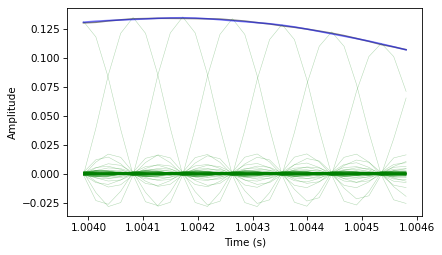

In [49]:
start = short.start + 0.004
duration = 0.00061
plot_sinc_demo(short, 4, start, duration)
decorate_time()

The line across the top is the original wave.
The vertical gray lines show the sampled values.
The thin curves are the shifted, scaled copies of the sinc function.
The sum of these sinc functions is identical to the original wave.

Read that last sentence again, because it is more surprising than it might seem.
Because we started with a signal that contained no energy above 5512 Hz, and we sampled at 11,025 Hz, we were able to recover the original spectrum exactly.

In this example, I started with a wave that had already been sampled at 44,100 Hz, and I resampled it at 11,025 Hz. After resampling, the gap between the spectral copies is the sampling rate, 11.025 kHz.
If the original signal contains components that exceed half of the sampling rate, 5512 Hz, the copies overlap and we lose information.

But if the signal is "bandwidth limited"; that is, it contains no energy above 5512 Hz, the spectral copies don't overlap, we don't lose information, and we can recover the original signal exactly.

This result is known as the Nyquist-Shannon sampling theorem (see <https://en.wikipedia.org/wiki/Nyquist-Shannon_sampling_theorem>).

This example does not prove the Sampling Theorem, but I hope it helps you understand what it says and why it works.

Notice that the argument I made does not depend on the original sampling rate, 44.1 kHz.
The result would be the same if the original had been sampled at a higher frequency, or even if the original had been a continuous analog signal: if we sample at framerate $f$, we can recover the original signal exactly, as long as it contains no energy at frequencies above $f/2$.

Chris "Monty" Montgomery has an excellent video called "D/A and A/D \| Digital Show and Tell"; it demonstrates the Sampling Theorem in action, and presents lots of other excellent information about sampling.
Watch it at <https://www.youtube.com/watch?v=cIQ9IXSUzuM>.



## Exercises

### Exercise 11.1

As we have seen, if you sample a signal at too low a framerate, frequencies above the folding frequency get aliased.
Once that happens, it is no longer possible to filter out these components, because they are indistinguishable from lower frequencies.

It is a good idea to filter out these frequencies *before* sampling; a low-pass filter used for this purpose is called an "anti-aliasing filter".

Returning to the drum solo example, apply a low-pass filter before sampling, then apply the low-pass filter again to remove the spectral copies introduced by sampling.
The result should be identical to the filtered signal.


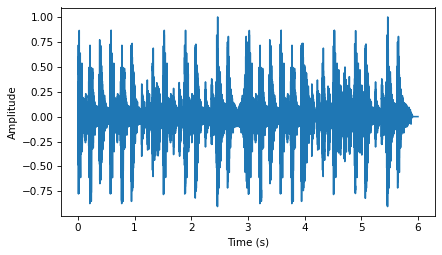

In [50]:
wave = read_wave('263868__kevcio__amen-break-a-160-bpm.wav')
wave.normalize()
wave.plot()
decorate_time()

This signal is sampled at 44100 Hz.  Here's what it sounds like.

In [52]:
wave.make_audio()

And here's the spectrum:

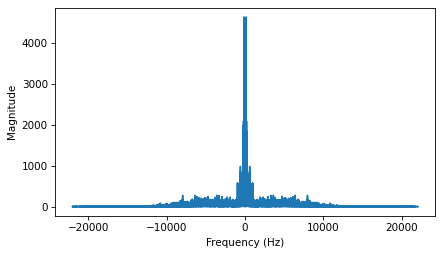

In [53]:
spectrum = wave.make_spectrum(full=True)
spectrum.plot()
decorate_freq()

I'll reduce the sampling rate by a factor of 3 (but you can change this to try other values):

In [54]:
factor = 3
framerate = wave.framerate / factor
cutoff = framerate / 2 - 1

Before sampling we apply an anti-aliasing filter to remove frequencies above the new folding frequency, which is `framerate/2`:

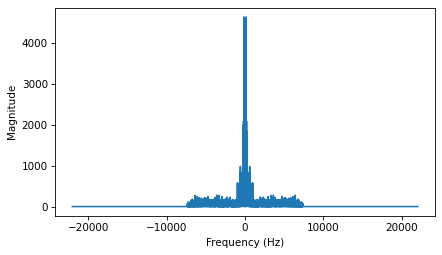

In [55]:
spectrum.low_pass(cutoff)
spectrum.plot()
decorate_freq()

Here's what it sounds like after filtering (still pretty good).

In [56]:
filtered = spectrum.make_wave()
filtered.make_audio()

Here's the function that simulates the sampling process:

In [57]:
from thinkdsp import Wave

def sample(wave, factor):
    """Simulates sampling of a wave.
    
    wave: Wave object
    factor: ratio of the new framerate to the original
    """
    ys = np.zeros(len(wave))
    ys[::factor] = np.real(wave.ys[::factor])
    return Wave(ys, framerate=wave.framerate)

The result contains copies of the spectrum near 20 kHz; they are not very noticeable:

In [58]:
sampled = sample(filtered, factor)
sampled.make_audio()

But they show up when we plot the spectrum:

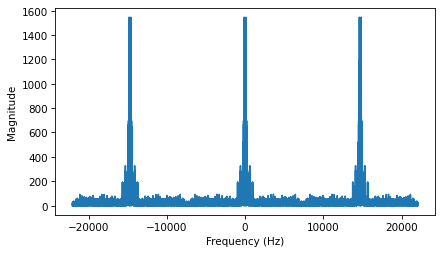

In [59]:
sampled_spectrum = sampled.make_spectrum(full=True)
sampled_spectrum.plot()
decorate_freq()

We can get rid of the spectral copies by applying the anti-aliasing filter again:

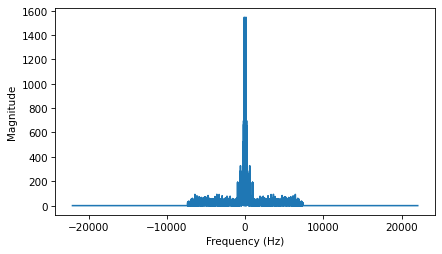

In [60]:
sampled_spectrum.low_pass(cutoff)
sampled_spectrum.plot()
decorate_freq()

We just lost half the energy in the spectrum, but we can scale the result to get it back:

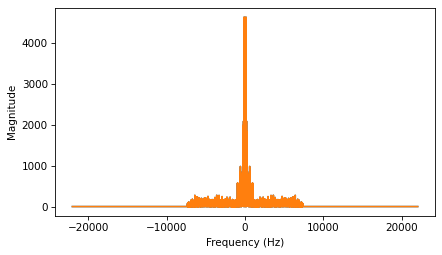

In [61]:
sampled_spectrum.scale(factor)
spectrum.plot()
sampled_spectrum.plot()
decorate_freq()

Now the difference between the spectrum before and after sampling should be small.

In [62]:
spectrum.max_diff(sampled_spectrum)

9.374856803373542e-13

After filtering and scaling, we can convert back to a wave:

In [63]:
interpolated = sampled_spectrum.make_wave()
interpolated.make_audio()

And the difference between the interpolated wave and the filtered wave should be small.

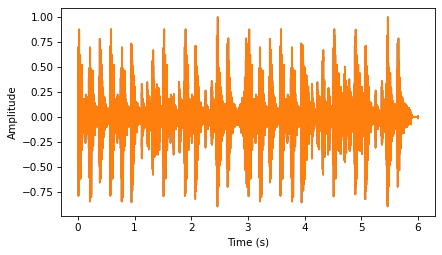

In [64]:
filtered.plot()
interpolated.plot()
decorate_time()

In [65]:
filtered.max_diff(interpolated)

5.658995448385304e-16

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)